In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"axes.axisbelow": True})
from scipy.stats import ks_2samp

In [2]:
news_citations_df = pd.read_parquet(
    "../../data/intermediate/citation_analysis/news_citations.parquet"
)

In [3]:
len(news_citations_df)

32865

In [16]:
news_citations_df_leaning = news_citations_df[
    news_citations_df.political_leaning_score.notna()
]
news_citations_df_quality = news_citations_df[
    news_citations_df.domain_quality_score.notna()
]

In [5]:
len(news_citations_df_leaning)

32405

In [17]:
len(news_citations_df_quality)

26540

In [18]:
provider_colors = {
    "gpt": "#2E3440",
    "gemini": "#B66A97",
    "perplexity": "#20808D",
}

provider_names = {
    "gpt": "OpenAI",
    "perplexity": "Perplexity",
    "gemini": "Google",
}

providers = ["gpt", "perplexity", "gemini"]

In [7]:
family_data = news_citations_df_leaning[
    news_citations_df_leaning["model_family"] == "perplexity"
]

In [8]:
len(family_data.query("political_leaning_score > 0.33")) / len(family_data)

0.01194014553653787

In [9]:
dict(family_data.political_leaning.value_counts(normalize=True))

{'center_leaning': np.float64(0.7519216972430051),
 'left_leaning': np.float64(0.2361381572204571),
 'right_leaning': np.float64(0.01194014553653787)}

In [10]:
# Print summary statistics
print("Leaning Score Distribution Summary:")
print("=" * 50)
leaning_pct = {}
for family in providers:
    family_data = news_citations_df_leaning[
        news_citations_df_leaning["model_family"] == family
    ]
    mean_score = family_data["political_leaning_score"].mean()
    median_score = family_data["political_leaning_score"].median()
    std_score = family_data["political_leaning_score"].std()
    leaning_pct[family] = dict(
        family_data.political_leaning.value_counts(normalize=True)
    )
    total = len(family_data)

    print(f"{family.upper()}:")
    print(f"  Citations with leaning scores: {total:,}")
    print(f"  Mean leaning score: {mean_score:.3f}")
    print(f"  Median leaning score: {median_score:.3f}")
    print(f"  Std deviation: {std_score:.3f}")
    for leaning in ["left_leaning", "center_leaning", "right_leaning"]:
        print(leaning, f"{leaning_pct[family][leaning] * 100:.1f}%")

Leaning Score Distribution Summary:
GPT:
  Citations with leaning scores: 7,572
  Mean leaning score: -0.237
  Median leaning score: -0.224
  Std deviation: 0.129
left_leaning 14.5%
center_leaning 85.2%
right_leaning 0.3%
PERPLEXITY:
  Citations with leaning scores: 19,514
  Mean leaning score: -0.215
  Median leaning score: -0.217
  Std deviation: 0.192
left_leaning 23.6%
center_leaning 75.2%
right_leaning 1.2%
GEMINI:
  Citations with leaning scores: 5,319
  Mean leaning score: -0.225
  Median leaning score: -0.209
  Std deviation: 0.181
left_leaning 26.3%
center_leaning 72.8%
right_leaning 0.8%


In [19]:
# Print summary statistics
print("Quality Score Distribution Summary:")
print("=" * 50)
high_quality_pct = {}
for family in providers:
    family_data = news_citations_df_quality[
        news_citations_df_quality["model_family"] == family
    ]
    mean_score = family_data["domain_quality_score"].mean()
    median_score = family_data["domain_quality_score"].median()
    std_score = family_data["domain_quality_score"].std()
    above_half = (family_data["domain_quality_score"] > 0.5).sum()
    total = len(family_data)

    high_quality_pct[family] = above_half / total * 100

    print(f"{family.upper()}:")
    print(f"  Citations with quality scores: {total:,}")
    print(f"  Mean quality score: {mean_score:.3f}")
    print(f"  Median quality score: {median_score:.3f}")
    print(f"  Std deviation: {std_score:.3f}")
    print(f"  Above threshold (>0.5): {above_half:,} ({above_half / total * 100:.1f}%)")
    print()

Quality Score Distribution Summary:
GPT:
  Citations with quality scores: 6,772
  Mean quality score: 0.872
  Median quality score: 0.910
  Std deviation: 0.154
  Above threshold (>0.5): 6,516 (96.2%)

PERPLEXITY:
  Citations with quality scores: 15,519
  Mean quality score: 0.757
  Median quality score: 0.805
  Std deviation: 0.156
  Above threshold (>0.5): 14,311 (92.2%)

GEMINI:
  Citations with quality scores: 4,249
  Mean quality score: 0.729
  Median quality score: 0.768
  Std deviation: 0.160
  Above threshold (>0.5): 3,813 (89.7%)



In [20]:
print("Cross family leaning stats tests")
for family_1 in providers:
    for family_2 in providers:
        if family_1 != family_2:
            family_1_data = news_citations_df_leaning[
                news_citations_df_leaning["model_family"] == family_1
            ]
            family_2_data = news_citations_df_leaning[
                news_citations_df_leaning["model_family"] == family_2
            ]
            stats, p = ks_2samp(
                family_1_data.political_leaning_score,
                family_2_data.political_leaning_score,
            )
            print(family_1, family_2, stats, p)

Cross family leaning stats tests
gpt perplexity 0.26117961498756814 0.0
gpt gemini 0.3021278114012232 3.45358974045737e-252
perplexity gpt 0.26117961498756814 0.0
perplexity gemini 0.0523077101831701 2.2202491788314795e-10
gemini gpt 0.3021278114012232 3.45358974045737e-252
gemini perplexity 0.0523077101831701 2.2202491788314795e-10


In [21]:
print("Cross family quality stats tests")
for family_1 in providers:
    for family_2 in providers:
        if family_1 != family_2:
            family_1_data = news_citations_df_quality[
                news_citations_df_quality["model_family"] == family_1
            ]
            family_2_data = news_citations_df_quality[
                news_citations_df_quality["model_family"] == family_2
            ]
            stats, p = ks_2samp(
                family_1_data.domain_quality_score, family_2_data.domain_quality_score
            )
            print(family_1, family_2, stats, p)

Cross family quality stats tests
gpt perplexity 0.455376346971285 0.0
gpt gemini 0.49366606812179287 3.444e-321
perplexity gpt 0.455376346971285 0.0
perplexity gemini 0.14475076679667676 1.8364713794028036e-61
gemini gpt 0.49366606812179287 3.444e-321
gemini perplexity 0.14475076679667676 1.8364713794028036e-61


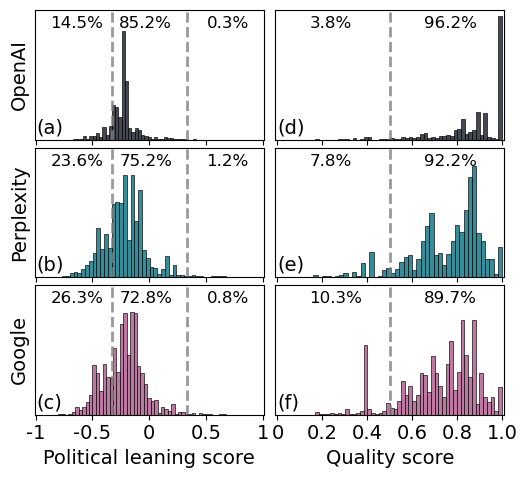

In [115]:
# Create figure with subfigures for quality score distribution by model family
fig = plt.figure(figsize=(5.5, 5))

ylim = {
    "political_leaning_score": {
        "gpt": 12,
        'perplexity': 4,
        'gemini': 4
    },
    "domain_quality_score": {
        "gpt": 25,
        'perplexity': 7,
        'gemini': 7
    }
}

for fi, df, col in [
    [1, news_citations_df_leaning, 'political_leaning_score'],
     [2, news_citations_df_quality, 'domain_quality_score']
    ]:
    for i, family in enumerate(providers):
        plt.subplot(3, 2, i*2 + fi)
        # Filter data for this family with non-null quality scores
        family_data = df[
            df["model_family"] == family
        ]
    
        # Create histogram
        plt.hist(
            family_data[col],
            bins=50,
            alpha=0.9,
            color=provider_colors[family],
            edgecolor="black",
            linewidth=0.5,
            density=True,
        )
        plt.ylim([0, ylim[col][family]])    
        # Add vertical lines
        if col == "political_leaning_score":
            plt.axvline(x=-0.33, color="gray", linestyle="--", linewidth=2, alpha=0.8)
            plt.axvline(x=0.33, color="gray", linestyle="--", linewidth=2, alpha=0.8)
            xs = [-1, -0.5, 0, 0.5, 1]
            plt.xlim([-1.01, 1.01])
            if i == 2:
                plt.xlabel("Political leaning score")
                plt.xticks(xs, xs)
            else:
                plt.xticks(xs, [])
        else:
            plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=2, alpha=0.8)
            xs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
            plt.xlim([-0.01, 1.01])
            if i == 2:
                plt.xlabel("Quality score")
                plt.xticks(xs, xs)
            else:
                plt.xticks(xs, [])

        if fi == 1:
            plt.ylabel(provider_names[family])
        plt.yticks([], [])

        pct_y = 0.86
        if col == "political_leaning_score":
            for x, y, text, alignment in [
                [0.30, pct_y, f"{leaning_pct[family]['left_leaning'] * 100:.1f}%", 'right'],
                [0.37, pct_y, f"{leaning_pct[family]['center_leaning'] * 100:.1f}%", 'left'],
                [0.75, pct_y, f"{leaning_pct[family]['right_leaning'] * 100:.1f}%", 'left'],
            ]:
                plt.text(x, y, text, transform=plt.gca().transAxes, fontsize=12, horizontalalignment=alignment,)
            plt.text(0.01, 0.05, f"({'abc'[i]})", transform = plt.gca().transAxes)

        if col == "domain_quality_score":
            for x, y, text, alignment in [
                [0.15, pct_y, f"{100 - high_quality_pct[family]:.1f}%", 'left'],
                [0.65, pct_y, f"{high_quality_pct[family]:.1f}%", 'left'],
            ]:
                plt.text(x, y, text, transform=plt.gca().transAxes, fontsize=12, horizontalalignment=alignment,)
            plt.text(0.01, 0.05, f"({'def'[i]})", transform = plt.gca().transAxes)
plt.tight_layout(h_pad=0.15, w_pad=0.1)
plt.savefig("../../data/output/citation_analysis/model_family_leaning_quality_distribution.pdf")